In [45]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import re
from tensorflow.keras import layers, models
import sklearn.metrics as metrics
from numpy.fft import fft, fft2, rfft, rfft2, fftfreq, fftshift
import scipy.signal as signal
from tensorflow_addons.metrics import F1Score
import tensorflow_addons as tfa
import scipy

%matplotlib notebook

In [46]:
data_root = Path('.')/'data'

In [47]:
target_folder = data_root/'2020'
student_pattern = "s\d{7}"

files = {}
for (dirpath, dirnames, filenames) in os.walk(target_folder):
  s_match = re.search(student_pattern, dirpath)
  # if regex matches, and files exist
  if s_match and filenames:
    s = s_match.group()
    # print(f"adding files for {s} (in {dirpath})")
    dir = Path(dirpath)
    try: files[s]
    except KeyError: files[s] = []
    # only accept .csv files
    files[s].extend([dir/f for f in filenames if f[-4:] == '.csv'])

print("File count:")
{k: len(v) for (k, v) in files.items()}

File count:


{'s1621503': 84,
 's1704037': 79,
 's1736273': 84,
 's1735229': 84,
 's1701688': 84,
 's1737472': 78,
 's1758009': 84,
 's1710228': 84,
 's1660711': 84,
 's1655560': 84,
 's1655552': 90,
 's1768094': 225,
 's1770036': 78,
 's1707651': 65,
 's2124639': 89,
 's2017768': 87,
 's1721039': 79,
 's1751093': 79,
 's1746788': 84,
 's1758499': 84,
 's1709221': 78,
 's1711507': 236,
 's1642301': 84,
 's1764751': 92,
 's1616573': 112}

In [127]:
ACTIVITY_CODE_TO_TFCODE_MAPPING = {
  0:   0,   # "Sitting",
  4:   1,   # "Sitting bent forward",
  5:   2,   # "Sitting bent backward",
  1:   3,   # "Walking at normal speed",
  100: 4,   # "Standing",
  2:   5,   # "Lying down on back",
  7:   6,   # "Lying down left",
  6:   7,   # "Lying down right",
  8:   8,   # "Lying down on stomach",
  9:   9,   # "Movement",
  11:  10,  # "Running",
  12:  11,  # "Climbing stairs",
  13:  12,  # "Descending stairs",
  31:  13,  # "Desk work"
}

ACTIVITY_TFCODE_TO_CODE_MAPPING = {
  0:  0,   # "Sitting",
  1:  4,   # "Sitting bent forward",
  2:  5,   # "Sitting bent backward",
  3:  1,   # "Walking at normal speed",
  4:  100, # "Standing",
  5:  2,   # "Lying down on back",
  6:  7,   # "Lying down left",
  7:  6,   # "Lying down right",
  8:  8,   # "Lying down on stomach",
  9:  9,   # "Movement",
  10: 11,  # "Running",
  11: 12,  # "Climbing stairs",
  12: 13,  # "Descending stairs",
  13: 31,  # "Desk work"
}

LABELS = {
    0:  "Sitting",
    1:  "Sitting bent forward",
    2:  "Sitting bent backward",
    3:  "Walking at normal speed",
    4:  "Standing",
    5:  "Lying down on back",
    6:  "Lying down left",
    7:  "Lying down right",
    8:  "Lying down on stomach",
    9:  "Movement",
    10: "Running",
    11: "Climbing stairs",
    12: "Descending stairs",
    13: "Desk work"
}

CLASSES = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 3,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 5, 
    11: 6,
    12: 7,
    13: 0
}
"""
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 0,
    5: 2,
    6: 2,
    7: 2,
    8: 2,
    9: 1,
    10: 3, 
    11: 1,
    12: 1,
    13: 0
}"""

CLASS_LABELS = {
    0: "Sitting",
    1: "Walking",
    2: "Standing",
    3: "Lying",
    4: "Movement",
    5: "Running",
    6: "Climbing Stairs",
    7: "Descending stairs"
}

CLASS_LABELS_NOMO = {
    0: "Sitting",
    1: "Walking",
    2: "Standing",
    3: "Lying",
    5: "Running",
    6: "Climbing Stairs",
    7: "Descending stairs"
}
"""
    0: "Stationary",
    1: "Walking",
    2: "Lying",
    3: "Running",
    0: "Sitting",
}"""

'\n    0: "Stationary",\n    1: "Walking",\n    2: "Lying",\n    3: "Running",\n    0: "Sitting",\n}'

In [49]:
from dataclasses import dataclass

header_size = 5

@dataclass
class Header:
  sensor_pos: str
  sensor_side: str
  act_type: str
  act_code: np.ndarray
  subject_id: str
  # https://stackoverflow.com/a/54863771/9184658
  def __post_init__(self):
    self.act_code = ACTIVITY_CODE_TO_TFCODE_MAPPING[int(self.act_code)]


@dataclass
class Activity:
  header: Header
  df: pd.DataFrame

def read_custom_file(filename):
  with open(filename) as f:
    head = [next(f).rstrip().split('# ')[1] for x in range(header_size)]
    header = Header(*[s.split(': ')[1] for s in head])
    # for l in head:
    #   print(l)
    # print(header)

    df = pd.read_csv(filename, header=header_size)
    return Activity(header, df)

In [50]:
def plot_respeck_fig(activity):
    fig = plt.figure(figsize=(10, 8))
    plt.plot(activity.df['accel_x'], label="accel_x")
    plt.plot(activity.df['accel_y'], label="accel_y")
    plt.plot(activity.df['accel_z'], label="accel_z")
    title = activity.header.subject_id + " " + activity.header.act_type  
    plt.title(title)  
    plt.legend()
    fig_name = "graphs/respeck_" + title + "_.png"
    plt.savefig(fig_name, bbox_inches='tight')
    return plt

In [51]:
def plot_array(arr):
    fig = plt.figure(figsize=(10, 8))
    plt.plot(arr[:,0], label="accel_x")
    plt.plot(arr[:,1], label="accel_y")
    plt.plot(arr[:,2], label="accel_z")
    plt.legend()
    return plt

In [52]:
act = read_custom_file(files["s1621503"][0])
act

Activity(header=Header(sensor_pos='Wrist', sensor_side='Right', act_type='Lying down right', act_code=7, subject_id='s1621503'), df=         timestamp  seq   accel_x   accel_y   accel_z
0    1601826499860    0  0.080566 -0.230530 -0.979065
1    1601826499938    1  0.081055 -0.230042 -0.978577
2    1601826500017    2  0.084961 -0.233215 -0.978333
3    1601826500096    3  0.083740 -0.231750 -0.979797
4    1601826500175    4  0.084473 -0.232483 -0.981750
..             ...  ...       ...       ...       ...
411  1601826532226  411  0.060547 -0.211487 -0.983704
412  1601826532305  412  0.060547 -0.207825 -0.989075
413  1601826532383  413  0.060303 -0.204407 -0.987366
414  1601826532462  414  0.061279 -0.208313 -0.986145
415  1601826532541  415  0.061523 -0.207092 -0.984924

[416 rows x 5 columns])

In [53]:
keys = ["accel_x", "accel_y", "accel_z"]

In [54]:
window_size = 100
step_size = 50

In [55]:
sensor_pos = 'Chest'
sensor_side = 'Right'

In [147]:
# split students into train and test set

students = list(files.keys())
print(len(students))

students.remove('s1735229')
students.remove('s1709221')

print(len(students))
    
split = int(len(students) * 0.8)
#train_students = #students[:split]
test_students = ['s1616573', 's1621503', 's1764751', 's1710228', 's1768094']#students[split:]
train_students = [s for s in students if s not in test_students]


25
23


In [148]:
colours = ['#E52700', '#E35500', '#E18100', '#E0AD00', '#DED800', '#B7DD00', '#8ADB00', '#5DD900', '#31D800', '#06D600', '#00D523', '#00D34D', '#00D276', '#00D09F', '#00CEC7', '#00ABCD', '#0081CB', '#0058CA', '#002FC8', '#0007C6', '#1F00C5', '#4600C3', '#6C00C2', '#9200C0', '#B600BF']

In [149]:
STUDENT_COLOURS = dict(zip(students, colours))

In [150]:
def get_activities(files, students, window_size, sensor_pos, sensor_side):
    student_files = [files[student] for student in students]

    activities = [read_custom_file(filename) for student in student_files for filename in student]
    activities = [activity for activity in activities if not activity.df.empty and len(activity.df.index) >= window_size and activity.header.sensor_pos == sensor_pos and activity.header.sensor_side == sensor_side and len(activity.df['accel_x']) < 1000 and activity.header.act_type != "Sitting or standing" ]
    
    return activities

In [151]:
train_activities = get_activities(files, train_students, window_size, sensor_pos, sensor_side)

test_activities = get_activities(files, test_students, window_size, sensor_pos, sensor_side)


In [152]:
train_student_acts = [activity.header.subject_id for activity in train_activities]
test_student_acts = [activity.header.subject_id for activity in test_activities]

In [153]:
def euclidean_norm(arr):
    return np.sum(np.abs(arr)**2,axis=1)**(1./2)

In [154]:
# X = data
# Y = labels

def create_data_arrays(activities):
    data = np.array([activity.df.get(keys).values for activity in activities], dtype=object)
    labels = np.array([activity.header.act_code for activity in activities])
    
    # sum each row 
    sums = [euclidean_norm(recording) for recording in data]
    
    data_means = [np.mean(s) for s in sums]
    data_stds = [np.std(s) for s in sums]
    
    return data, labels, data_means, data_stds

In [155]:
train_data_raw, train_labels_raw, train_means, train_stds = create_data_arrays(train_activities)
test_data_raw, test_labels_raw, test_means, test_stds = create_data_arrays(test_activities)

In [156]:
import itertools
def std_graphs(train_stds, train_labels_raw, test_stds, test_labels_raw, train_students_act, test_students_act):
    for i in range(14):
        activity = LABELS[i]
        stds_train = (list(itertools.compress(train_stds, (y == i for y in train_labels_raw))))
        stds_test = (list(itertools.compress(test_stds, (y == i for y in test_labels_raw))))
        
        train_studs = (list(itertools.compress(train_students_act, (y == i for y in train_labels_raw))))
        test_studs = (list(itertools.compress(test_students_act, (y == i for y in test_labels_raw))))

        train_colours = [STUDENT_COLOURS[s.lower()] for s in train_studs]
        test_colours = [STUDENT_COLOURS[s.lower()] for s in test_studs]
        
        y_max = max(max(stds_train), max(stds_test))
        y_min = min(min(stds_train), min(stds_test))
        
        width = 0.5
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        plt.title(activity)
        for i in range(len(stds_train)):
            ax1.bar(i, stds_train[i], width, color = train_colours[i])
        ax1.set_ylim([0, y_max])
        
        for i in range(len(stds_test)):
            ax2.bar(i, stds_test[i], width, color = test_colours[i])
        ax2.set_ylim([0, y_max])
        
        ax1.legend(train_studs, loc='upper left', bbox_to_anchor=(-0.8, 1))
        ax2.legend(test_studs, loc='upper left', bbox_to_anchor=(1.05, 1))
        
        #fig_name = "graphs/bar_std_" + activity + "_trimmed.png"
        #plt.savefig(fig_name, bbox_inches='tight')

<IPython.core.display.Javascript object>


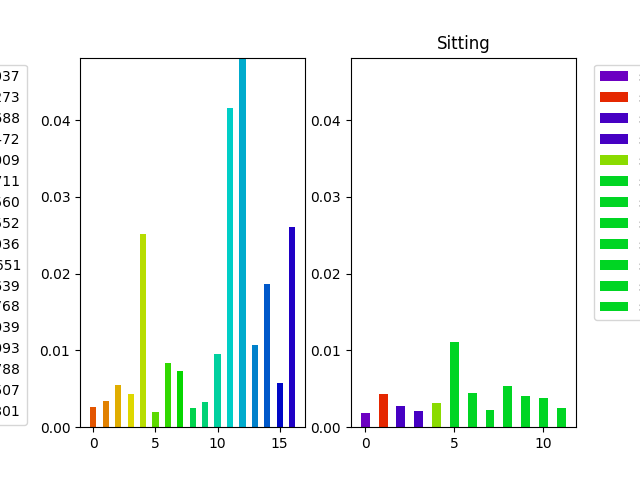

<IPython.core.display.Javascript object>


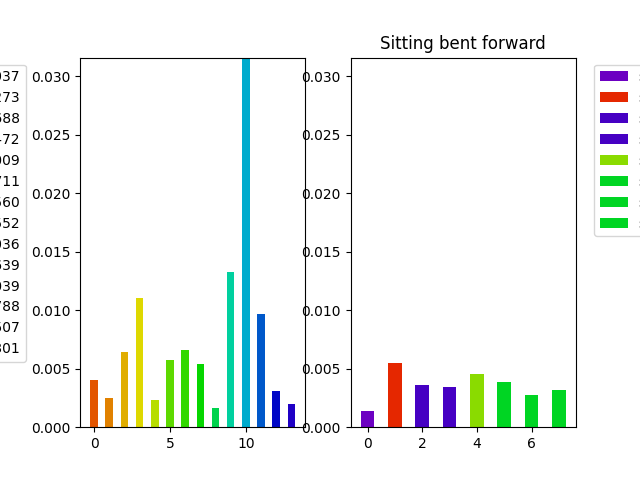

<IPython.core.display.Javascript object>


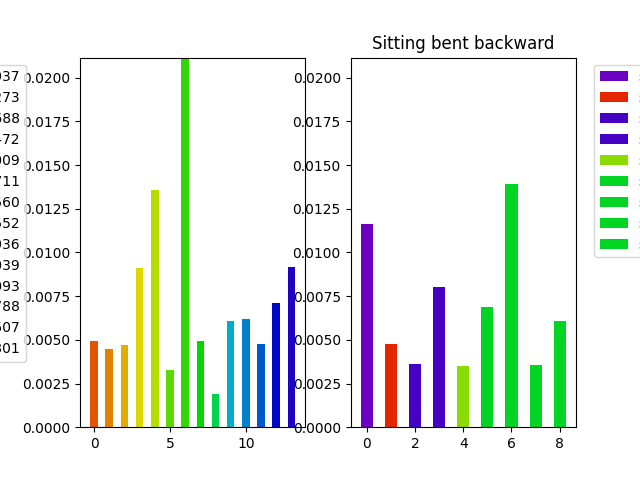

<IPython.core.display.Javascript object>


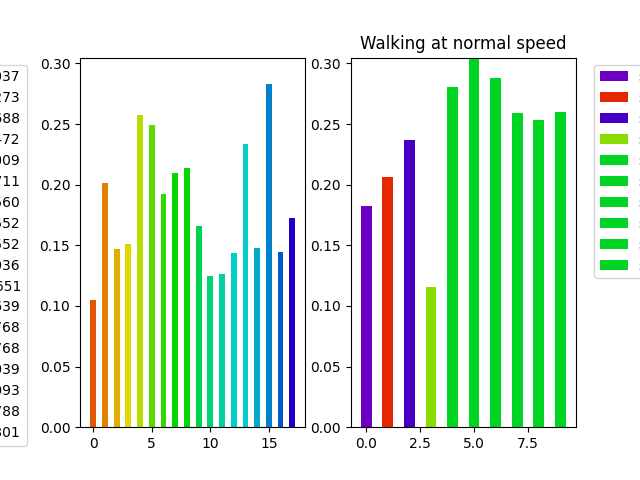

<IPython.core.display.Javascript object>


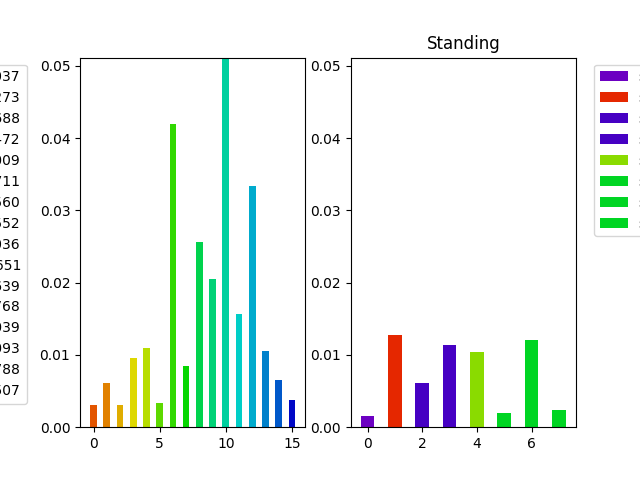

/home/c/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


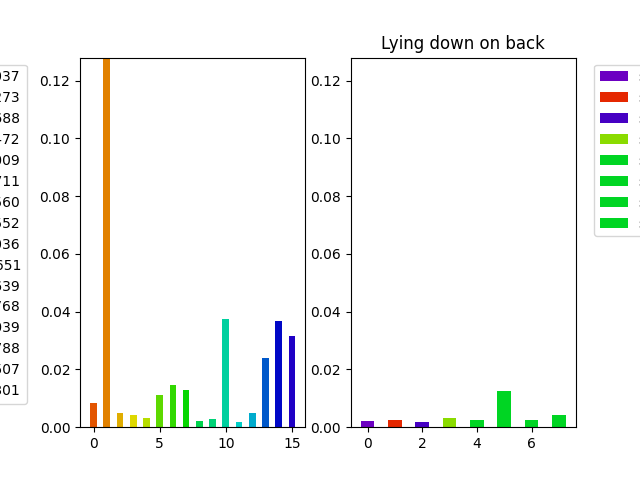

<IPython.core.display.Javascript object>


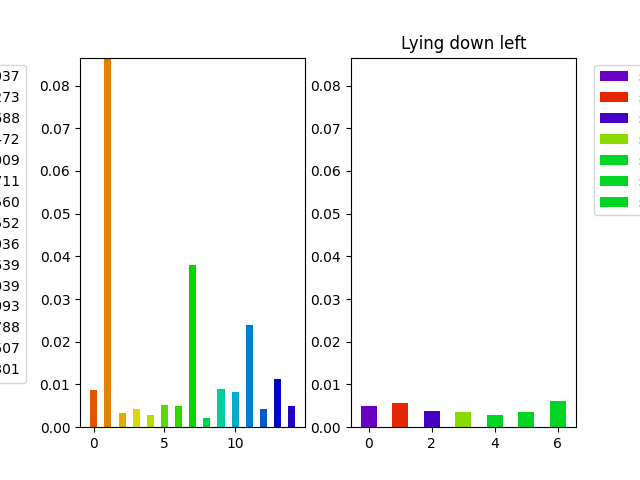

<IPython.core.display.Javascript object>


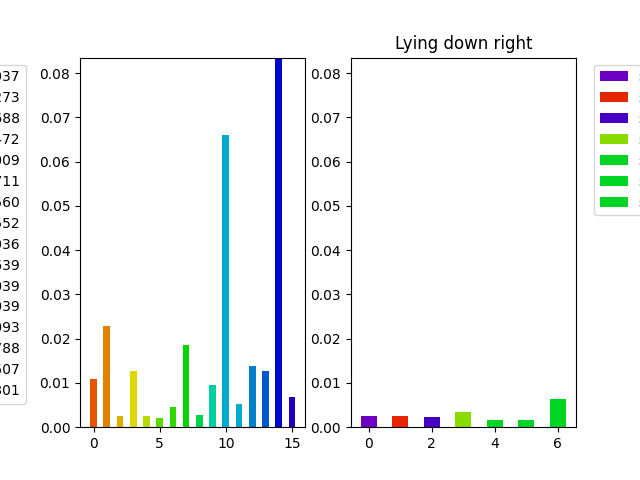

<IPython.core.display.Javascript object>


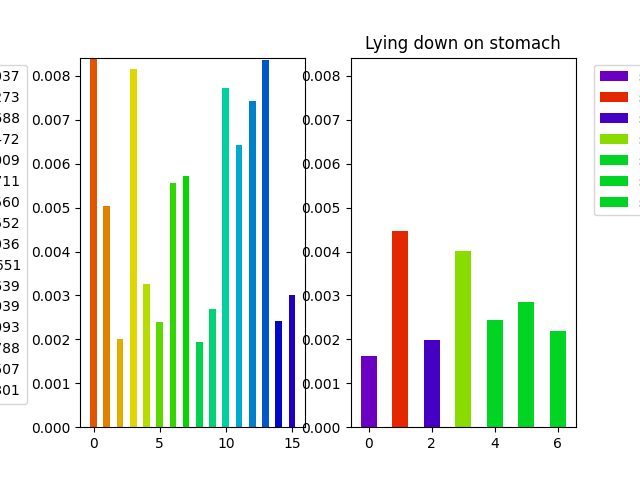

<IPython.core.display.Javascript object>


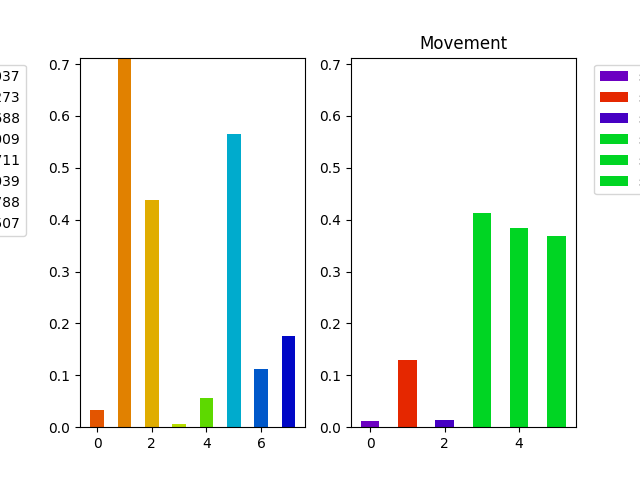

<IPython.core.display.Javascript object>


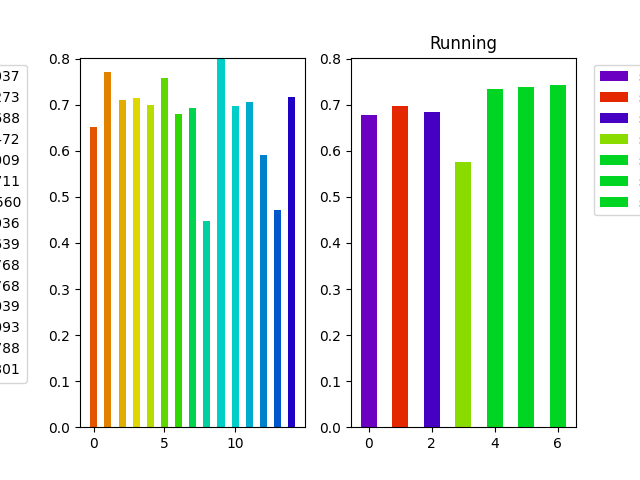

<IPython.core.display.Javascript object>


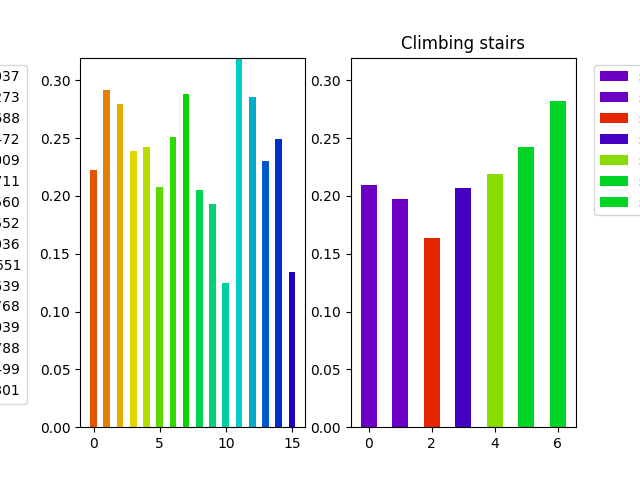

<IPython.core.display.Javascript object>


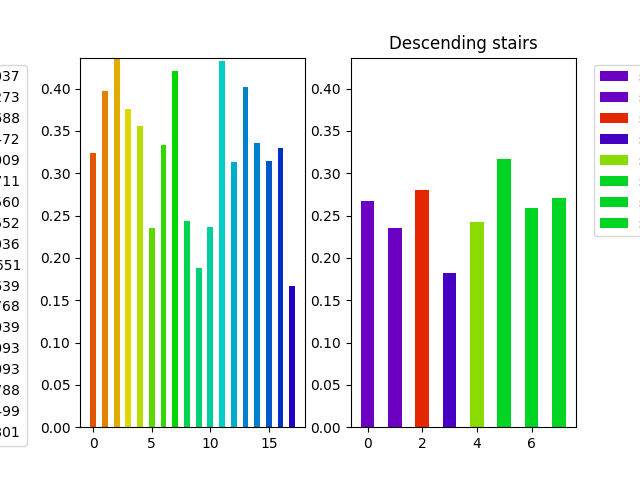

<IPython.core.display.Javascript object>


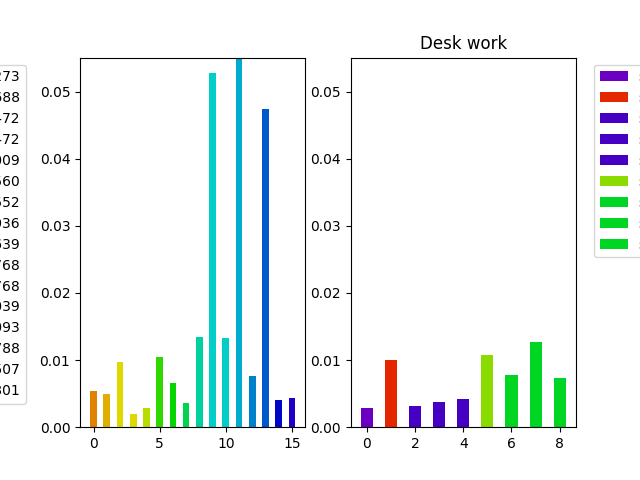

In [157]:
std_graphs(train_stds, train_labels_raw, test_stds, test_labels_raw, train_student_acts, test_student_acts)

In [158]:
def mean_graphs(train_means, train_labels, test_means, test_labels):
    for i in range(14):
        activity = LABELS[i]

        means_train = (list(itertools.compress(train_means, (y == i for y in train_labels))))
        means_test = (list(itertools.compress(test_means, (y == i for y in test_labels))))
        
        y_max = max(max(means_train), max(means_test))
        y_min = min(min(means_train), min(means_test))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.bar(range(len(means_train)), means_train, color='green')
        ax1.set_ylim([0, y_max])
        ax2.bar(range(len(means_test)), means_test, color='green')
        ax2.set_ylim([0, y_max])
        plt.title(activity)
        #fig_name = "graphs/bar_mean_" + activity + "_original.png"
        #plt.savefig(fig_name)

In [159]:
#mean_graphs(train_means, train_labels_raw, test_means, test_labels_raw)

In [160]:
"""for i in range(14):
    single_activity_train = [activity for activity in train_activities if activity.header.act_code == i]
    for activity in single_activity_train:
        plot_respeck_fig(activity)

    single_activity_test = [activity for activity in test_activities if activity.header.act_code == i]
    for activity in single_activity_test:
        plot_respeck_fig(activity)"""

'for i in range(14):\n    single_activity_train = [activity for activity in train_activities if activity.header.act_code == i]\n    for activity in single_activity_train:\n        plot_respeck_fig(activity)\n\n    single_activity_test = [activity for activity in test_activities if activity.header.act_code == i]\n    for activity in single_activity_test:\n        plot_respeck_fig(activity)'

In [161]:
"""data_to_smooth = [np.array(activity.df.get(keys).values) for activity in test_activities if activity.header.act_code==0 and activity.header.subject_id=='s1709221'][0]
smoothed_data = smooth([data_to_smooth], 10)
plot_array(smoothed_data[0])
"""

arr = [1,2,3,4,5,6,7,8,9]
arr[-2:]

[8, 9]

In [162]:
def trim_data(data, size):
    trimmed_data = np.array([d[size:-size] for d in data])
    return trimmed_data

In [163]:
def trim_data_stats(data, size, data_means, data_stds, data_labels):
    trimmed_data_arr = []
    trimmed = set()
    for i in range(len(data_means)):
        data_i = data[i]
        trimmed_data = data_i
        
        centred_data = np.zeros(data_i.shape)
        for j in range(2):
            centred_data[:,j] = data_i[:,j] - np.mean(data_i[:,j]) 
        
        mag_i = euclidean_norm(centred_data)
        #print(data_i.shape, len(mag_i))
        
        #mn = np.mean(mag_i[size:-size])
        #std = np.std(mag_i[size:-size])
        
        #data_stds.sort()
        #data_stds = data_stds[2:-2] 
        
        #print(LABELS[data_labels[i]])
        print(data_labels[i])
        
        
        mn = np.mean(mag_i[size:-size])
        std = np.std(mag_i[size:-size])
        while np.mean(mag_i[:size]) > mn + 3*std or np.mean(mag_i[:size]) <  mn - 3*std:
            trimmed_data = trimmed_data[size:]
            mag_i = mag_i[size:]
            
            mn = np.mean(mag_i[size:-size])
            std = np.std(mag_i[size:-size])
            print("trim_start")
            trimmed.add(i)
        
        mn = np.mean(mag_i[:-size])
        std = np.std(mag_i[:-size])
        # trim start and end if the are outside std window 
        while np.mean(mag_i[-size:]) > mn + 3*std or np.mean(mag_i[-size:]) <  mn - 3*std:
            trimmed_data = trimmed_data[:-size]
            mag_i = mag_i[:-size]
            
            mn = np.mean(mag_i[size:-size])
            std = np.std(mag_i[size:-size])
            print("trim_end")
            trimmed.add(i)
            
       
        
        trimmed_data_arr.append(trimmed_data)
            
    return np.array(trimmed_data_arr), trimmed

In [164]:
train_data_trimmed, train_trimmed_ind = trim_data_stats(train_data_raw, 25, train_means, train_stds, train_labels_raw)#trim_data(train_data_raw, 10)
test_data_trimmed, test_trimmed_ind = trim_data_stats(test_data_raw, 25, test_means, test_stds, test_labels_raw)#trim_data(test_data_raw, 10)

sums = [euclidean_norm(recording) for recording in train_data_trimmed]
train_data_trimmed_means = [np.mean(s) for s in sums]
train_data_trimmed_stds = [np.std(s) for s in sums]

sums = [euclidean_norm(recording) for recording in test_data_trimmed]
test_data_trimmed_means = [np.mean(s) for s in sums]
test_data_trimmed_stds = [np.std(s) for s in sums]

print(train_data_raw.shape)
print(train_data_trimmed.shape)
print(test_data_raw.shape)
print(test_data_trimmed.shape)

2
7
trim_start
trim_start
8
trim_start
trim_start
trim_start
1
11
9
5
trim_start
10
0
12
3
4
trim_start
6
trim_start
8
7
trim_start
5
trim_start
11
1
0
2
4
trim_start
13
trim_start
12
9
3
6
trim_start
trim_start
10
5
0
trim_start
3
4
8
1
trim_start
trim_start
9
2
12
13
10
7
11
6
trim_start
0
trim_start
5
trim_start
trim_start
8
trim_start
trim_start
1
trim_start
trim_start
12
11
13
6
trim_start
trim_start
4
trim_start
13
2
trim_start
10
3
7
10
3
6
7
trim_start
5
8
12
11
0
trim_start
trim_start
13
trim_start
2
9
1
4
trim_start
9
6
trim_start
trim_start
trim_end
2
5
trim_start
1
trim_start
3
11
10
8
7
trim_start
trim_start
trim_start
0
4
trim_start
12
6
trim_start
trim_start
trim_start
11
0
12
10
13
1
trim_start
5
trim_start
8
trim_start
7
trim_start
3
2
trim_start
trim_start
4
trim_start
trim_start
11
3
2
7
trim_start
8
trim_start
0
3
5
6
trim_start
4
trim_start
1
trim_start
13
trim_start
12
6
trim_start
3
10
12
7
trim_start
5
2
8
trim_start
11
4
trim_start
0
13
1
trim_start
8
trim_star

In [165]:
"""for i in train_trimmed_ind:
    print(train_activities[i].header.subject_id + " " + train_activities[i].header.act_type)
    plot_array(train_data_trimmed[i])"""
print(len(train_trimmed_ind))    

83


In [166]:
#std_graphs(train_data_trimmed_stds, train_labels_raw, test_data_trimmed_stds, test_labels_raw, train_student_acts, test_student_acts)


In [167]:
# the Euclidean norm (vector magnitude) of the three raw signals minus 1, referred to as ENMO; 
def enmo(data):
    arr_enmo = []
    
    for arr in data:
        norm = np.sum(np.abs(arr)**2,axis=-1)**(1./2) - 1.0
        norm[norm < 0] = 0
        arr_enmo.append(np.c_[arr, norm])
    
    return np.array(arr_enmo)

In [168]:
#https://www.biorxiv.org/content/biorxiv/early/2018/02/13/263046.full.pdf
def orientation_angle(data):
    #(tan^-1(acc_x/sqrt(acc_y^2+acc_z^2)))180/pi
    return 0

In [169]:
# https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

def smooth(data, box_pts):
    box = np.ones(box_pts)/box_pts
    data_smooth = []
    for arr in data:
        data_smooth.append(scipy.ndimage.convolve1d(arr, box, mode='reflect', axis=0))
    return np.array(data_smooth)

In [170]:
def standardize(X):
    x = (X - np.mean(X,axis=0))/np.std(X,axis=0)
    return x

def standardize_array(data_raw):
    data = np.zeros(data_raw.shape, dtype=object)
    
    for i in range(len(data)):
        data[i] = (standardize(data_raw[i]))
        
    return data

In [171]:
# standardize input data

train_data = train_data_trimmed #enmo(train_data_raw) #smooth(train_data_raw, 10) # standardize_array(train_data_raw)

test_data = test_data_trimmed #enmo(test_data_raw) #smooth(test_data_raw, 10) # standardize_array(test_data_raw)

In [172]:
 def get_full_class_stats(data, labels):
    means = []
    stds = []
    for i in range(14):
        act_list = (list(itertools.compress(data, (y == i for y in labels))))
        full_list = np.concatenate(act_list, axis=0)

        sums = euclidean_norm(full_list)
        means.append(np.mean(sums))
        stds.append(np.std(sums))
    return means, stds

In [173]:
# filter using training mean
train_class_means, train_class_stds = get_full_class_stats(train_data, train_labels_raw)

print(train_class_means)
print(train_class_stds)

[0.9977662347202542, 1.0259265531434925, 0.985441212062284, 1.0302555612324038, 1.0134502341599392, 0.9615104859006451, 1.00103274311394, 0.9829529790855299, 1.0123313185319094, 1.0584403855779303, 1.0877305630805092, 1.0341956821290113, 1.028072299211712, 1.0047810504694756]
[0.03680633603072202, 0.04241972952501415, 0.023630233828102358, 0.19066129487536723, 0.03235676141191439, 0.030254648401735525, 0.03564827756122215, 0.02153128216479306, 0.03700875809198868, 0.3484578085752135, 0.6731005538434801, 0.2477245443397838, 0.3413427998962412, 0.03941803549356485]


In [174]:
def window_data(data_array, label_array, window_size, step_size, class_means, class_stds, hamming = False, remove_movement = False, filter_outliers = False):
    windowed_data = []
    windowed_labels = []
    
    for i in range(len(label_array)):
        arr = data_array[i]
        label = label_array[i]
        
        #data_mean = data_means[i] 
        #data_std = data_stds[i]
        
        start_i = 0
        end_i = start_i + window_size

        while end_i < arr.shape[0]:
            if hamming:
                window = arr[start_i:end_i] * np.hamming(window_size)[:,None]
            else:
                window = arr[start_i:end_i]
            if not(remove_movement and label == 9):
                # filter out outlier windows 
                win_mag = euclidean_norm(window)
                within_2_std = np.mean(win_mag) <= class_means[label] + 2*class_stds[label] and np.mean(win_mag) >=  class_means[label] - 2*class_stds[label]
                if not(filter_outliers) or within_2_std:
                    windowed_data.append(window)
                    windowed_labels.append(label)
            start_i = start_i + step_size
            end_i = start_i + window_size
        
    return np.array(windowed_data), np.array(windowed_labels)

In [175]:
# https://gist.github.com/vishalkuo/f4aec300cf6252ed28d3
def interquartile_filer(data, data_stds, data_labels, std_labels):
    results = []
    labels = []
    for i in range(14):
        if i !=9 or 9 in data_labels:
            window = (list(itertools.compress(data, (y == i for y in data_labels))))
            act_stds = (list(itertools.compress(data_stds, (y == i for y in std_labels))))
            upper_quartile = np.percentile(act_stds, 75)
            lower_quartile = np.percentile(act_stds, 25)
            IQR = (upper_quartile - lower_quartile) * 1.5
            quartileSet = [lower_quartile - IQR, upper_quartile + IQR]

            result = (list(itertools.compress(window, ((y >= quartileSet[0]) & (y <= quartileSet[1]) for y in act_stds)))) 
            labels.extend([i]*len(result))
            results.extend(result)
        
    return np.array(results), np.array(labels)

In [176]:
train_data_win, train_label_win = window_data(train_data, train_labels_raw, window_size, step_size, train_class_means, train_class_stds, False, True, False)

test_data_win, test_label_win = window_data(test_data, test_labels_raw, window_size, step_size, train_class_means, train_class_stds, False, True, False)

print(train_data_win.shape)
print(train_label_win.shape)

print(test_data_win.shape)
print(test_label_win.shape)

(1679, 100, 3)
(1679,)
(743, 100, 3)
(743,)


In [177]:
def std_boxplot(train_stds, train_labels, test_stds, test_labels):
    for i in range(14):
        activity = LABELS[i]
        #means = (list(itertools.compress(train_means, (y == i for y in train_labels_raw))))
        stds_train = (list(itertools.compress(train_stds, (y == i for y in train_labels))))
        stds_test = (list(itertools.compress(test_stds, (y == i for y in test_labels))))
        #plt.figure()
        #plt.bar(range(len(means)), means, color='blue')
        #plt.title("Mean")
        #plt.show()
        #y_max = max(max(stds_train), max(stds_test))
        #y_min = min(min(stds_train), min(stds_test))
        plt.figure()
        plt.title(activity)
        plt.boxplot([stds_train, stds_test], labels=['Train', 'Test'])
        #plt.show()
        #fig_name = "graphs/box_std_" + activity + "_filtered_iqr.png"
        #plt.savefig(fig_name)

In [178]:
# remove window if mean and std are too different 
sums = [euclidean_norm(recording) for recording in train_data_win]
train_data_win_stds = [np.std(s) for s in sums]

sums = [euclidean_norm(recording) for recording in test_data_win]
test_data_win_stds = [np.std(s) for s in sums]

In [179]:
train_data_win_iqr, train_labels_win_iqr = interquartile_filer(train_data_win, train_data_win_stds, train_label_win, train_label_win)
test_data_win_iqr, test_labels_win_iqr = interquartile_filer(test_data_win, train_data_win_stds, test_label_win, train_label_win)

print(train_data_win_iqr.shape)
print(train_labels_win_iqr.shape)
print(test_data_win_iqr.shape)
print(test_labels_win_iqr.shape)


train_data_win = train_data_win_iqr
train_label_win = train_labels_win_iqr
test_data_win = test_data_win_iqr
test_label_win = test_labels_win_iqr

(1579, 100, 3)
(1579,)
(718, 100, 3)
(718,)


In [180]:
sums = [euclidean_norm(recording) for recording in train_data_win_iqr]
train_data_iqr_stds = [np.std(s) for s in sums]

sums = [euclidean_norm(recording) for recording in test_data_win_iqr]
test_data_iqr_stds = [np.std(s) for s in sums]

In [181]:
#std_boxplot(train_data_iqr_stds, train_labels_win_iqr, test_data_iqr_stds, test_labels_win_iqr)

In [182]:
def fftransform(windowed_data):
    
    fft_data = []
    
    filter_freq = 0.1 * 12.5 / 2 #12.5*0.01
    
    overlap = 10
    window_size = 25
    
    for i in range(len(windowed_data)):
        window_spec = []
        
        arr = windowed_data[i]

        start_i = 0
        end_i = start_i + window_size

        while end_i <= arr.shape[0]:
            window = arr[start_i:end_i] * np.hamming(window_size)[:,None]
            
            mag = np.abs(fft(window, axis = 0)) 
            
            
            
            mag[mag > filter_freq] = 0
            
            window_spec.append(mag)
            
            start_i = end_i - overlap
            end_i = start_i + window_size
        fft_data.append(window_spec)
    
    
    freqs = fftfreq(len(mag[0]), d=1.0/12.5)
    return np.array(fft_data)

In [183]:
def make_spectrogram(windowed_data):
    f, t, Sxx = signal.spectrogram(windowed_data[:,:,0], fs=12.5, axis=1)
    return f, t, Sxx

In [184]:
train_fft = fftransform(train_data_win)
test_fft = fftransform(test_data_win)

#f, t, Sxx = make_spectrogram(train_data_win)
#plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')


In [185]:
# one hot encoding of output labels

train_labels = np.array(pd.get_dummies(train_label_win))
test_labels = np.array(pd.get_dummies(test_label_win))

In [186]:
train_labels_grouped = np.array([CLASSES[i] for i in train_label_win])
test_labels_grouped = np.array([CLASSES[i] for i in test_label_win])

In [187]:
train_labels_grouped = np.array(pd.get_dummies(train_labels_grouped))
test_labels_grouped = np.array(pd.get_dummies(test_labels_grouped))

In [188]:
f1_score = F1Score(num_classes=13, average='macro')
f1_score_grouped = F1Score(num_classes=8, average='macro')
f1_score_no_move = F1Score(num_classes=7, average='macro')#F1Score(num_classes=4, average='macro')


In [189]:
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [110]:
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
# fit and evaluate a model
def evaluate_model_batch_norm(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score_no_move])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [111]:
def evaluate_model_batch_norm_2d(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_bins, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainX.shape[3], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_bins, n_features)))
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score_no_move])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [112]:
def evaluate_model_group_norm_2d(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_bins, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainX.shape[3], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_bins, n_features)))
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    #save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [113]:
# fit and evaluate a model
def evaluate_model_2(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [114]:
def evaluate_model_cnn_lstm(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 15, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    n_steps, n_length = 4, 25
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    
    model = models.Sequential()
    model.add(layers.TimeDistributed(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_length, n_features))))
    model.add(layers.TimeDistributed(layers.Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dropout(0.5)))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)))
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.LSTM(100))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score_no_move])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    #save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [115]:
def evaluate_model_cnn_lstm_2d(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 20, 32
    n_timesteps, n_bins, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainX.shape[3], trainy.shape[1]
    
    n_steps, n_length = 2, 3
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_bins, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_bins, n_features))
    
    model = models.Sequential()
    model.add(layers.TimeDistributed(layers.Conv2D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_length, n_bins, n_features))))
    model.add(layers.TimeDistributed(layers.Conv2D(filters=64, kernel_size=2, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dropout(0.5)))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling2D(pool_size=1)))
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.LSTM(100))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score_no_move])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    #save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [116]:
# summarize scores
def summarize_results(scores, name):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('%s: %.3f%% (+/-%.3f)' % (name, m, s))


In [117]:
# run an experiment
def run_experiment(trainX, trainy, testX, testy, repeats=1):
    # repeat experiment
    scores = list()
    f1scores = list()
    models = list()
    for r in range(repeats):
        score, f1score = evaluate_model_batch_norm(trainX, trainy, testX, testy, r)
        score = score * 100.0
        f1score = f1score * 100.0 
        print('>#%d: Acc %.3f F1 %.3f' % (r+1, score, f1score))
        scores.append(score)
        f1scores.append(f1score)
        models.append
    # summarize results
    summarize_results(scores, 'Accuracy')
    summarize_results(f1scores, 'F1 Score')
    
def run_experiment_2d(trainX, trainy, testX, testy, repeats=1):
    # repeat experiment
    scores = list()
    f1scores = list()
    models = list()
    for r in range(repeats):
        score, f1score = evaluate_model_batch_norm_2d(trainX, trainy, testX, testy, r)
        score = score * 100.0
        f1score = f1score * 100.0 
        print('>#%d: Acc %.3f F1 %.3f' % (r+1, score, f1score))
        scores.append(score)
        f1scores.append(f1score)
        models.append
    # summarize results
    summarize_results(scores, 'Accuracy')
    summarize_results(f1scores, 'F1 Score')
    
def save_model(model, n):
    # Convert the model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    model_filename = 'models/cnn_model_fft_grouped_iqr_removed_s1709221_s1735229_trimming_mean_centered_flipped_' + str(n) + '_' + sensor_pos + '_' + sensor_side + '.tflite' 
    # Save the model.
    with open(model_filename, 'wb') as f:
        f.write(tflite_model)

In [151]:
run_experiment(train_data_win, train_labels, test_data_win, test_labels, 5)

Epoch 1/40
62/62 [==============================] - 1s 10ms/step - loss: 1.6351 - accuracy: 0.4507 - f1_score: 0.4592
Epoch 2/40
62/62 [==============================] - 0s 7ms/step - loss: 1.1975 - accuracy: 0.5676 - f1_score: 0.5754
Epoch 3/40
62/62 [==============================] - 0s 7ms/step - loss: 0.9745 - accuracy: 0.6274 - f1_score: 0.6339
Epoch 4/40
62/62 [==============================] - 0s 7ms/step - loss: 0.9138 - accuracy: 0.6422 - f1_score: 0.6499
Epoch 5/40
62/62 [==============================] - 0s 7ms/step - loss: 0.8036 - accuracy: 0.6764 - f1_score: 0.6804
Epoch 6/40
62/62 [==============================] - 0s 7ms/step - loss: 0.7568 - accuracy: 0.7014 - f1_score: 0.7045
Epoch 7/40
62/62 [==============================] - 1s 9ms/step - loss: 0.7631 - accuracy: 0.6983 - f1_score: 0.6994
Epoch 8/40
62/62 [==============================] - 0s 8ms/step - loss: 0.6646 - accuracy: 0.7346 - f1_score: 0.7371
Epoch 9/40
62/62 [==============================] - 0s 7ms/step

INFO:tensorflow:Assets written to: /tmp/tmphb7d431y/assets


>#1: Acc 50.733 F1 51.881
Epoch 1/40
62/62 [==============================] - 1s 12ms/step - loss: 1.7341 - accuracy: 0.4507 - f1_score: 0.4711
Epoch 2/40
62/62 [==============================] - 1s 14ms/step - loss: 1.1867 - accuracy: 0.5702 - f1_score: 0.5811
Epoch 3/40
62/62 [==============================] - 1s 14ms/step - loss: 0.9991 - accuracy: 0.6131 - f1_score: 0.6227
Epoch 4/40
62/62 [==============================] - 1s 12ms/step - loss: 0.8503 - accuracy: 0.6585 - f1_score: 0.6661
Epoch 5/40
62/62 [==============================] - 1s 12ms/step - loss: 0.7986 - accuracy: 0.6810 - f1_score: 0.6860
Epoch 6/40
62/62 [==============================] - 1s 11ms/step - loss: 0.7865 - accuracy: 0.6907 - f1_score: 0.6975
Epoch 7/40
62/62 [==============================] - 1s 11ms/step - loss: 0.7133 - accuracy: 0.7095 - f1_score: 0.7133
Epoch 8/40
62/62 [==============================] - 1s 12ms/step - loss: 0.6976 - accuracy: 0.7131 - f1_score: 0.7165
Epoch 9/40
62/62 [============

INFO:tensorflow:Assets written to: /tmp/tmppkbsgqce/assets


>#2: Acc 43.695 F1 46.503
Epoch 1/40
62/62 [==============================] - 1s 8ms/step - loss: 1.6569 - accuracy: 0.4523 - f1_score: 0.4604
Epoch 2/40
62/62 [==============================] - 1s 9ms/step - loss: 1.1009 - accuracy: 0.5717 - f1_score: 0.5847
Epoch 3/40
62/62 [==============================] - 1s 10ms/step - loss: 0.9016 - accuracy: 0.6544 - f1_score: 0.6610
Epoch 4/40
62/62 [==============================] - 1s 10ms/step - loss: 0.8010 - accuracy: 0.6810 - f1_score: 0.6866
Epoch 5/40
62/62 [==============================] - 1s 10ms/step - loss: 0.7351 - accuracy: 0.7101 - f1_score: 0.7139
Epoch 6/40
62/62 [==============================] - 1s 10ms/step - loss: 0.7571 - accuracy: 0.6932 - f1_score: 0.6952
Epoch 7/40
62/62 [==============================] - 1s 11ms/step - loss: 0.6312 - accuracy: 0.7463 - f1_score: 0.7484
Epoch 8/40
62/62 [==============================] - 1s 11ms/step - loss: 0.6587 - accuracy: 0.7392 - f1_score: 0.7393
Epoch 9/40
62/62 [==============

INFO:tensorflow:Assets written to: /tmp/tmp_z75mi3q/assets


>#3: Acc 55.132 F1 55.369
Epoch 1/40
62/62 [==============================] - 1s 9ms/step - loss: 1.7390 - accuracy: 0.4390 - f1_score: 0.4638
Epoch 2/40
62/62 [==============================] - 1s 12ms/step - loss: 1.1419 - accuracy: 0.5748 - f1_score: 0.5821
Epoch 3/40
62/62 [==============================] - 1s 11ms/step - loss: 1.0056 - accuracy: 0.6105 - f1_score: 0.6190
Epoch 4/40
62/62 [==============================] - 1s 11ms/step - loss: 0.8900 - accuracy: 0.6503 - f1_score: 0.6550
Epoch 5/40
62/62 [==============================] - 1s 10ms/step - loss: 0.7788 - accuracy: 0.6876 - f1_score: 0.6930
Epoch 6/40
62/62 [==============================] - 1s 11ms/step - loss: 0.7692 - accuracy: 0.7055 - f1_score: 0.7089
Epoch 7/40
62/62 [==============================] - 1s 11ms/step - loss: 0.7183 - accuracy: 0.7198 - f1_score: 0.7245
Epoch 8/40
62/62 [==============================] - 1s 12ms/step - loss: 0.6435 - accuracy: 0.7417 - f1_score: 0.7451
Epoch 9/40
62/62 [=============

INFO:tensorflow:Assets written to: /tmp/tmppty7410m/assets


>#4: Acc 57.771 F1 57.553
Epoch 1/40
62/62 [==============================] - 1s 8ms/step - loss: 1.6456 - accuracy: 0.4625 - f1_score: 0.4867
Epoch 2/40
62/62 [==============================] - 1s 12ms/step - loss: 1.1546 - accuracy: 0.5748 - f1_score: 0.5826
Epoch 3/40
62/62 [==============================] - 1s 11ms/step - loss: 0.9603 - accuracy: 0.6202 - f1_score: 0.6267
Epoch 4/40
62/62 [==============================] - 1s 10ms/step - loss: 0.8661 - accuracy: 0.6549 - f1_score: 0.6606
Epoch 5/40
62/62 [==============================] - 1s 10ms/step - loss: 0.7885 - accuracy: 0.6825 - f1_score: 0.6860
Epoch 6/40
62/62 [==============================] - 1s 10ms/step - loss: 0.7272 - accuracy: 0.7060 - f1_score: 0.7131
Epoch 7/40
62/62 [==============================] - 1s 10ms/step - loss: 0.6227 - accuracy: 0.7555 - f1_score: 0.7584
Epoch 8/40
62/62 [==============================] - 1s 10ms/step - loss: 0.6380 - accuracy: 0.7499 - f1_score: 0.7509
Epoch 9/40
62/62 [=============

INFO:tensorflow:Assets written to: /tmp/tmpektvp0a7/assets


>#5: Acc 49.267 F1 49.833
[50.733137130737305, 43.6950147151947, 55.13196587562561, 57.77125954627991, 49.266862869262695]
Accuracy: 51.320% (+/-4.875)
[51.88077688217163, 46.50333821773529, 55.36908507347107, 57.55252242088318, 49.83283281326294]
F1 Score: 52.228% (+/-3.920)


In [ ]:
run_experiment(train_data_win, train_labels_grouped, test_data_win, test_labels_grouped, 5)

Epoch 1/40
62/62 [==============================] - 1s 10ms/step - loss: 1.2111 - accuracy: 0.5773 - f1_score: 0.4361
Epoch 2/40
62/62 [==============================] - 1s 10ms/step - loss: 0.7647 - accuracy: 0.6927 - f1_score: 0.5914
Epoch 3/40
62/62 [==============================] - 1s 13ms/step - loss: 0.6131 - accuracy: 0.7524 - f1_score: 0.6735
Epoch 4/40
62/62 [==============================] - 1s 8ms/step - loss: 0.5645 - accuracy: 0.7626 - f1_score: 0.6877
Epoch 5/40
62/62 [==============================] - 1s 9ms/step - loss: 0.5288 - accuracy: 0.7785 - f1_score: 0.7030
Epoch 6/40
62/62 [==============================] - 1s 10ms/step - loss: 0.4686 - accuracy: 0.8025 - f1_score: 0.7468
Epoch 7/40
62/62 [==============================] - 0s 7ms/step - loss: 0.4753 - accuracy: 0.8055 - f1_score: 0.7599
Epoch 8/40
62/62 [==============================] - 1s 9ms/step - loss: 0.4152 - accuracy: 0.8244 - f1_score: 0.7845
Epoch 9/40
62/62 [==============================] - 1s 9ms/s

INFO:tensorflow:Assets written to: /tmp/tmpffg_u4kg/assets


>#1: Acc 63.636 F1 54.776
Epoch 1/40
62/62 [==============================] - 1s 9ms/step - loss: 1.2394 - accuracy: 0.5794 - f1_score: 0.4608
Epoch 2/40
62/62 [==============================] - 1s 10ms/step - loss: 0.7299 - accuracy: 0.7111 - f1_score: 0.6087
Epoch 3/40
62/62 [==============================] - 1s 11ms/step - loss: 0.6630 - accuracy: 0.7397 - f1_score: 0.6552
Epoch 4/40
62/62 [==============================] - 1s 11ms/step - loss: 0.6124 - accuracy: 0.7580 - f1_score: 0.6899
Epoch 5/40
62/62 [==============================] - 1s 11ms/step - loss: 0.5143 - accuracy: 0.7897 - f1_score: 0.7324
Epoch 6/40
62/62 [==============================] - 1s 11ms/step - loss: 0.4562 - accuracy: 0.8096 - f1_score: 0.7587
Epoch 7/40
62/62 [==============================] - 1s 12ms/step - loss: 0.4115 - accuracy: 0.8326 - f1_score: 0.7927
Epoch 8/40
62/62 [==============================] - 1s 11ms/step - loss: 0.3721 - accuracy: 0.8453 - f1_score: 0.8115
Epoch 9/40
62/62 [=============

INFO:tensorflow:Assets written to: /tmp/tmphcrsqzns/assets


>#2: Acc 70.381 F1 55.975
Epoch 1/40
62/62 [==============================] - 1s 9ms/step - loss: 1.1975 - accuracy: 0.5926 - f1_score: 0.4810
Epoch 2/40
62/62 [==============================] - 1s 9ms/step - loss: 0.7292 - accuracy: 0.7111 - f1_score: 0.6040
Epoch 3/40
62/62 [==============================] - 1s 10ms/step - loss: 0.6029 - accuracy: 0.7575 - f1_score: 0.6770
Epoch 4/40
62/62 [==============================] - 1s 10ms/step - loss: 0.5545 - accuracy: 0.7672 - f1_score: 0.7017
Epoch 5/40
62/62 [==============================] - 1s 10ms/step - loss: 0.4913 - accuracy: 0.7882 - f1_score: 0.7203
Epoch 6/40
62/62 [==============================] - 1s 10ms/step - loss: 0.4232 - accuracy: 0.8244 - f1_score: 0.7725
Epoch 7/40
62/62 [==============================] - 1s 11ms/step - loss: 0.3964 - accuracy: 0.8356 - f1_score: 0.7923
Epoch 8/40
62/62 [==============================] - 1s 11ms/step - loss: 0.3889 - accuracy: 0.8336 - f1_score: 0.7940
Epoch 9/40
62/62 [==============

INFO:tensorflow:Assets written to: /tmp/tmpf0e6yf0d/assets


>#3: Acc 78.299 F1 63.328
Epoch 1/40
62/62 [==============================] - 1s 9ms/step - loss: 1.1728 - accuracy: 0.6023 - f1_score: 0.5025
Epoch 2/40
62/62 [==============================] - 1s 10ms/step - loss: 0.7300 - accuracy: 0.7177 - f1_score: 0.6219
Epoch 3/40
62/62 [==============================] - 1s 11ms/step - loss: 0.6285 - accuracy: 0.7478 - f1_score: 0.6656
Epoch 4/40
62/62 [==============================] - 1s 10ms/step - loss: 0.5283 - accuracy: 0.7759 - f1_score: 0.7190
Epoch 5/40
62/62 [==============================] - 1s 9ms/step - loss: 0.4911 - accuracy: 0.7907 - f1_score: 0.7268
Epoch 6/40
62/62 [==============================] - 1s 10ms/step - loss: 0.4801 - accuracy: 0.8019 - f1_score: 0.7468
Epoch 7/40
62/62 [==============================] - 1s 10ms/step - loss: 0.4308 - accuracy: 0.8188 - f1_score: 0.7765
Epoch 8/40
62/62 [==============================] - 1s 11ms/step - loss: 0.3612 - accuracy: 0.8474 - f1_score: 0.8199
Epoch 9/40
62/62 [==============

INFO:tensorflow:Assets written to: /tmp/tmpby73ma5g/assets


>#4: Acc 64.516 F1 62.742
Epoch 1/40
62/62 [==============================] - 0s 7ms/step - loss: 1.2071 - accuracy: 0.5901 - f1_score: 0.4646
Epoch 2/40
62/62 [==============================] - 1s 9ms/step - loss: 0.8419 - accuracy: 0.6876 - f1_score: 0.5959
Epoch 3/40
62/62 [==============================] - 1s 10ms/step - loss: 0.6745 - accuracy: 0.7213 - f1_score: 0.6405
Epoch 4/40
62/62 [==============================] - 1s 10ms/step - loss: 0.5806 - accuracy: 0.7550 - f1_score: 0.6748
Epoch 5/40
62/62 [==============================] - 1s 10ms/step - loss: 0.5522 - accuracy: 0.7754 - f1_score: 0.7021
Epoch 6/40
62/62 [==============================] - 1s 11ms/step - loss: 0.4538 - accuracy: 0.8173 - f1_score: 0.7726
Epoch 7/40
62/62 [==============================] - 1s 11ms/step - loss: 0.4240 - accuracy: 0.8208 - f1_score: 0.7734
Epoch 8/40
62/62 [==============================] - 1s 10ms/step - loss: 0.4067 - accuracy: 0.8392 - f1_score: 0.8117
Epoch 9/40
62/62 [==============

In [190]:
print(train_fft.shape)
run_experiment_2d(train_fft, train_labels_grouped, test_fft, test_labels_grouped, 5)

(1579, 6, 25, 3)
Epoch 1/40
50/50 [==============================] - 1s 11ms/step - loss: 0.9793 - accuracy: 0.6396 - f1_score: 0.4946
Epoch 2/40
50/50 [==============================] - 1s 12ms/step - loss: 0.6423 - accuracy: 0.7359 - f1_score: 0.6478
Epoch 3/40
50/50 [==============================] - 1s 12ms/step - loss: 0.5627 - accuracy: 0.7726 - f1_score: 0.7048
Epoch 4/40
50/50 [==============================] - 1s 12ms/step - loss: 0.5249 - accuracy: 0.7891 - f1_score: 0.7226
Epoch 5/40
50/50 [==============================] - 1s 13ms/step - loss: 0.4743 - accuracy: 0.8176 - f1_score: 0.7757
Epoch 6/40
50/50 [==============================] - 0s 8ms/step - loss: 0.4713 - accuracy: 0.8132 - f1_score: 0.7700
Epoch 7/40
50/50 [==============================] - 0s 7ms/step - loss: 0.3831 - accuracy: 0.8619 - f1_score: 0.8388
Epoch 8/40
50/50 [==============================] - 0s 7ms/step - loss: 0.3830 - accuracy: 0.8721 - f1_score: 0.8537
Epoch 9/40
50/50 [========================

INFO:tensorflow:Assets written to: /tmp/tmpan2lpchk/assets


>#1: Acc 74.791 F1 65.129
Epoch 1/40
50/50 [==============================] - 0s 10ms/step - loss: 1.0374 - accuracy: 0.5953 - f1_score: 0.5324
Epoch 2/40
50/50 [==============================] - 1s 11ms/step - loss: 0.6355 - accuracy: 0.7302 - f1_score: 0.6298
Epoch 3/40
50/50 [==============================] - 1s 12ms/step - loss: 0.6101 - accuracy: 0.7473 - f1_score: 0.6611
Epoch 4/40
50/50 [==============================] - 1s 11ms/step - loss: 0.5180 - accuracy: 0.7859 - f1_score: 0.7228
Epoch 5/40
50/50 [==============================] - 1s 11ms/step - loss: 0.4750 - accuracy: 0.8157 - f1_score: 0.7640
Epoch 6/40
50/50 [==============================] - 1s 11ms/step - loss: 0.4416 - accuracy: 0.8284 - f1_score: 0.7944
Epoch 7/40
50/50 [==============================] - 1s 11ms/step - loss: 0.4203 - accuracy: 0.8455 - f1_score: 0.8089
Epoch 8/40
50/50 [==============================] - 1s 12ms/step - loss: 0.3845 - accuracy: 0.8543 - f1_score: 0.8296
Epoch 9/40
50/50 [============

INFO:tensorflow:Assets written to: /tmp/tmprtb9w2vp/assets


>#2: Acc 73.538 F1 62.037
Epoch 1/40
50/50 [==============================] - 0s 7ms/step - loss: 1.0530 - accuracy: 0.6320 - f1_score: 0.5286
Epoch 2/40
50/50 [==============================] - 0s 7ms/step - loss: 0.6480 - accuracy: 0.7359 - f1_score: 0.6388
Epoch 3/40
50/50 [==============================] - 0s 7ms/step - loss: 0.5683 - accuracy: 0.7631 - f1_score: 0.6855
Epoch 4/40
50/50 [==============================] - 0s 7ms/step - loss: 0.5362 - accuracy: 0.7916 - f1_score: 0.7280
Epoch 5/40
50/50 [==============================] - 0s 7ms/step - loss: 0.4715 - accuracy: 0.8201 - f1_score: 0.7759
Epoch 6/40
50/50 [==============================] - 0s 7ms/step - loss: 0.4269 - accuracy: 0.8417 - f1_score: 0.8178
Epoch 7/40
50/50 [==============================] - 0s 7ms/step - loss: 0.3759 - accuracy: 0.8664 - f1_score: 0.8429
Epoch 8/40
50/50 [==============================] - 0s 6ms/step - loss: 0.3810 - accuracy: 0.8670 - f1_score: 0.8466
Epoch 9/40
50/50 [====================

INFO:tensorflow:Assets written to: /tmp/tmp7trp2wt5/assets


>#3: Acc 77.437 F1 64.924
Epoch 1/40
50/50 [==============================] - 0s 7ms/step - loss: 0.9582 - accuracy: 0.6504 - f1_score: 0.5547
Epoch 2/40
50/50 [==============================] - 0s 6ms/step - loss: 0.6282 - accuracy: 0.7454 - f1_score: 0.6514
Epoch 3/40
50/50 [==============================] - 0s 6ms/step - loss: 0.5570 - accuracy: 0.7796 - f1_score: 0.7123
Epoch 4/40
50/50 [==============================] - 0s 6ms/step - loss: 0.5280 - accuracy: 0.7847 - f1_score: 0.7196
Epoch 5/40
50/50 [==============================] - 0s 6ms/step - loss: 0.4778 - accuracy: 0.8113 - f1_score: 0.7603
Epoch 6/40
50/50 [==============================] - 0s 7ms/step - loss: 0.4160 - accuracy: 0.8467 - f1_score: 0.8215
Epoch 7/40
50/50 [==============================] - 0s 6ms/step - loss: 0.4035 - accuracy: 0.8461 - f1_score: 0.8209
Epoch 8/40
50/50 [==============================] - 0s 6ms/step - loss: 0.3606 - accuracy: 0.8683 - f1_score: 0.8501
Epoch 9/40
50/50 [====================

INFO:tensorflow:Assets written to: /tmp/tmpg38nf_as/assets


>#4: Acc 79.526 F1 66.155
Epoch 1/40
50/50 [==============================] - 1s 13ms/step - loss: 1.0029 - accuracy: 0.6194 - f1_score: 0.5271
Epoch 2/40
50/50 [==============================] - 1s 11ms/step - loss: 0.7011 - accuracy: 0.7226 - f1_score: 0.6224
Epoch 3/40
50/50 [==============================] - 1s 11ms/step - loss: 0.5817 - accuracy: 0.7568 - f1_score: 0.6746
Epoch 4/40
50/50 [==============================] - 1s 11ms/step - loss: 0.5656 - accuracy: 0.7783 - f1_score: 0.7086
Epoch 5/40
50/50 [==============================] - 1s 11ms/step - loss: 0.5145 - accuracy: 0.8037 - f1_score: 0.7535
Epoch 6/40
50/50 [==============================] - 0s 8ms/step - loss: 0.4604 - accuracy: 0.8246 - f1_score: 0.7850
Epoch 7/40
50/50 [==============================] - 0s 8ms/step - loss: 0.4104 - accuracy: 0.8505 - f1_score: 0.8263
Epoch 8/40
50/50 [==============================] - 0s 8ms/step - loss: 0.4046 - accuracy: 0.8512 - f1_score: 0.8305
Epoch 9/40
50/50 [===============

INFO:tensorflow:Assets written to: /tmp/tmpq1gkjr19/assets


>#5: Acc 78.134 F1 66.456
[74.79108572006226, 73.53760600090027, 77.43732333183289, 79.52646017074585, 78.1337022781372]
Accuracy: 76.685% (+/-2.201)
[65.12866616249084, 62.03683018684387, 64.92365002632141, 66.15510582923889, 66.45593643188477]
F1 Score: 64.940% (+/-1.565)


In [192]:
def get_predictions_from_saved_model(model_filename, testX):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_filename)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    predictions = []
    for x in testX:
        interpreter.set_tensor(input_details[0]['index'], [x])
    
        interpreter.invoke()
    
        predictions.append(interpreter.get_tensor(output_details[0]['index']))
    
    return np.array(predictions)

In [193]:
tf_filename = 'cnn_model_fft_grouped_iqr_removed_s1709221_s1735229_trimming_mean_centered_flipped_3_Chest_Right'
tf_filepath = 'models/' + tf_filename + '.tflite'
print(test_fft.shape)
predictions = get_predictions_from_saved_model(tf_filepath, np.array(test_fft, dtype=np.float32))

(718, 6, 25, 3)


In [194]:
predictions.shape

(718, 1, 7)

In [195]:
np.std(predictions, axis=2)

array([[0.22435617],
       [0.22579932],
       [0.22431745],
       [0.2245112 ],
       [0.22507666],
       [0.22471222],
       [0.32596943],
       [0.30830503],
       [0.30162364],
       [0.30997673],
       [0.3122626 ],
       [0.34782457],
       [0.33420572],
       [0.3444647 ],
       [0.31674442],
       [0.33285132],
       [0.3315749 ],
       [0.33242416],
       [0.32708758],
       [0.31949195],
       [0.31296912],
       [0.29225802],
       [0.33303306],
       [0.28504843],
       [0.29599753],
       [0.22823527],
       [0.32574105],
       [0.3050556 ],
       [0.33507296],
       [0.2665494 ],
       [0.31583542],
       [0.31616715],
       [0.23081422],
       [0.26822865],
       [0.34709662],
       [0.33659485],
       [0.32042128],
       [0.3078188 ],
       [0.33169568],
       [0.34024662],
       [0.3187274 ],
       [0.3196436 ],
       [0.23005395],
       [0.20272423],
       [0.20821159],
       [0.28619793],
       [0.30164915],
       [0.249

In [196]:
pred_labels = np.argmax(predictions, axis=2)

<IPython.core.display.Javascript object>


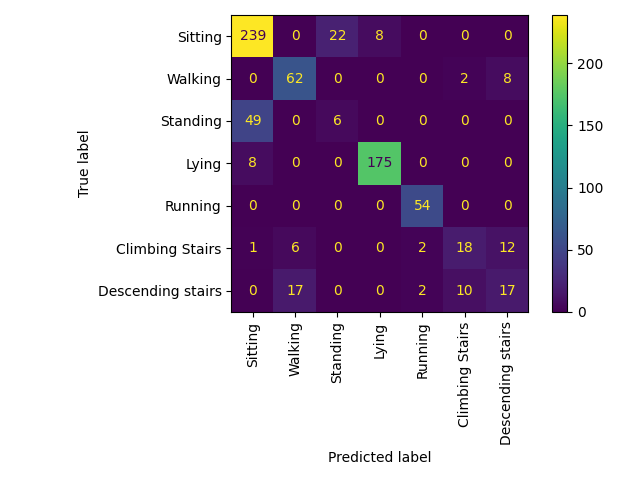

In [197]:
cm = metrics.confusion_matrix(np.argmax(test_labels_grouped, axis=1), pred_labels) # change to test_labels for all activities 

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LABELS_NOMO.values())
disp.plot(xticks_rotation='vertical')
plt.tight_layout()
plt.show()
plt.savefig(tf_filename + '.png')

In [46]:
standardisation = [31.55737817287445, 33.42026770114899, 30.02980649471283, 33.23397934436798, 30.29060959815979]
epochs_10 = [42.473918199539185, 39.71683979034424, 29.88077402114868, 39.30700421333313, 46.050670742988586]
epochs_20 = [41.840535402297974, 33.196720480918884, 37.89120614528656, 45.90163826942444, 38.226526975631714]
epochs_30 = [40.387481451034546, 45.566317439079285, 36.810728907585144, 43.3308482170105, 36.62444055080414]
epochs_40 = [39.82861340045929, 32.82414376735687, 42.324888706207275, 46.460506319999695, 43.66616904735565]

epochs_40_full_data = [38.40991258621216, 36.80949807167053, 47.70263433456421, 42.307692766189575, 39.029428362846375]
epochs_40_full_data_batch_normalisation = [44.166237115859985, 42.307692766189575, 45.018067955970764, 41.94630980491638, 41.58492386341095]
epochs_40_full_data_batch_normalisation_grouped = [62.98399567604065, 59.21528339385986, 63.810014724731445, 62.13216185569763, 55.60144782066345]


window_50_epochs_40 = [37.38650977611542, 37.87289261817932, 40.4020756483078, 38.197147846221924, 37.02983260154724]
window_150_epochs_40 = [46.45358920097351, 40.49912393093109, 42.3380047082901, 37.25919425487518, 44.78984177112579]

window_100_steps_50 = [63.56968283653259, 66.74816608428955, 62.59168982505798, 59.90220308303833, 58.92420411109924]
window_100_steps_25 = [63.499999046325684, 66.12499952316284, 63.24999928474426, 67.37499833106995, 62.87500262260437]

kernel_6 = [64.79217410087585, 46.454766392707825, 67.48166084289551, 68.9486563205719, 67.97065734863281]
kernel_9 = [57.21271634101868, 67.48166084289551, 65.28117656707764, 53.05623412132263, 46.21026813983917]

fft_grouped = [70.9046483039856, 69.68215107917786, 72.86063432693481, 72.86063432693481, 71.3936448097229]
fft_filtering_sqr = [68.21516156196594, 66.25916957855225, 67.48166084289551, 66.9926643371582, 67.48166084289551]
fft_filtering_01 = [70.66014409065247, 73.10513257980347, 73.10513257980347, 70.17114758491516, 71.8826413154602]

movement_removed = [76.40750408172607, 81.23324513435364, 78.28418016433716, 77.47989296913147, 75.33512115478516]

fft_ungrouped = [34.2298299074173, 35.4523241519928, 36.43031716346741, 37.408313155174255, 32.51833617687225]


layers_3_10 = [35.99105775356293, 33.79284739494324, 41.09537899494171, 41.46795868873596, 42.17585623264313]
layers_3_30 = [43.96423101425171, 35.58122217655182, 42.324888706207275, 43.8152015209198, 32.97317326068878]
layers_3_filters_32 = [39.493292570114136, 40.83457589149475, 31.929954886436462, 33.830103278160095, 39.67958390712738]
layers_3_filters_128 = [30.588674545288086, 46.16244435310364, 32.22801685333252, 30.81222176551819, 42.36214458942413]


<IPython.core.display.Javascript object>


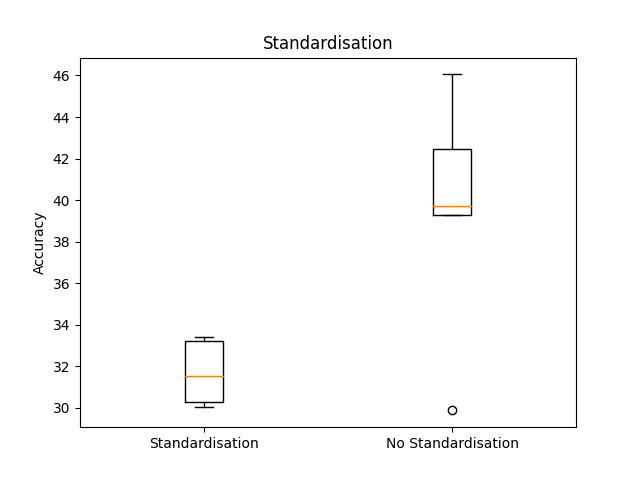

In [159]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Standardisation')
ax1.boxplot([standardisation, epochs_10], labels=['Standardisation', 'No Standardisation'])
plt.show()

<IPython.core.display.Javascript object>


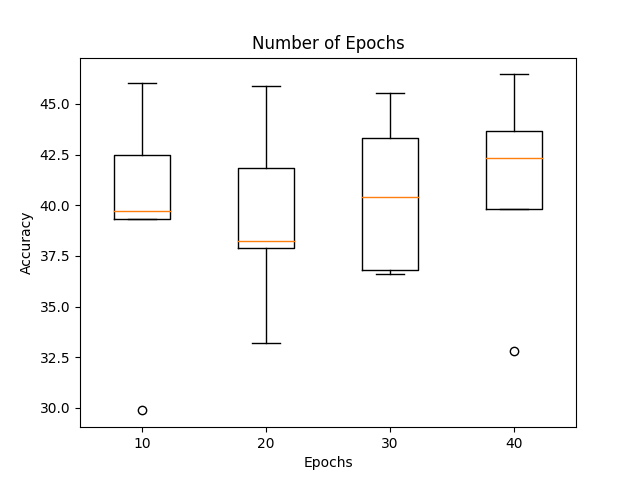

In [160]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Number of Epochs')
ax1.boxplot([epochs_10, epochs_20, epochs_30, epochs_40], labels=['10', '20', '30', '40'])
plt.show()

<IPython.core.display.Javascript object>


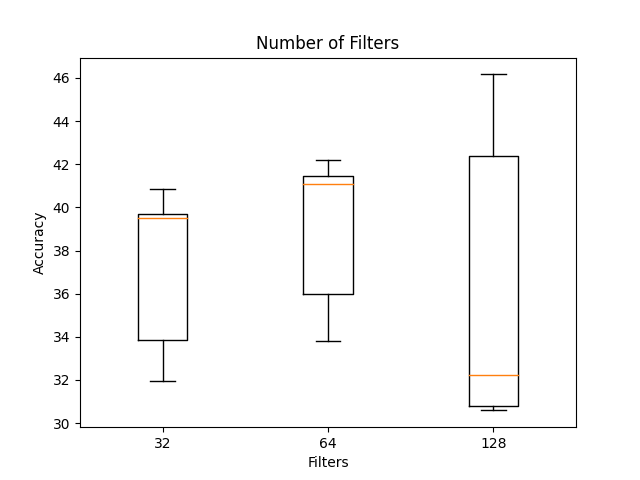

In [161]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Filters')
ax1.set_ylabel('Accuracy')
ax1.set_title('Number of Filters')
ax1.boxplot([layers_3_filters_32, layers_3_10, layers_3_filters_128], labels=['32', '64', '128'])
plt.show()

<IPython.core.display.Javascript object>


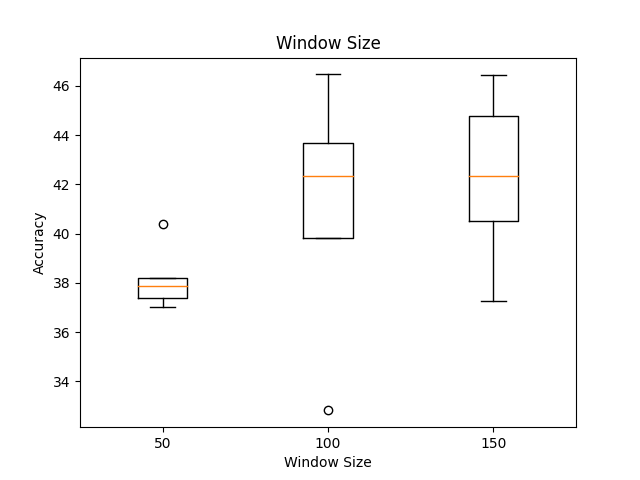

In [163]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Window Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Window Size')
ax1.boxplot([window_50_epochs_40, epochs_40, window_150_epochs_40], labels=['50', '100', '150'])
plt.show()

<IPython.core.display.Javascript object>


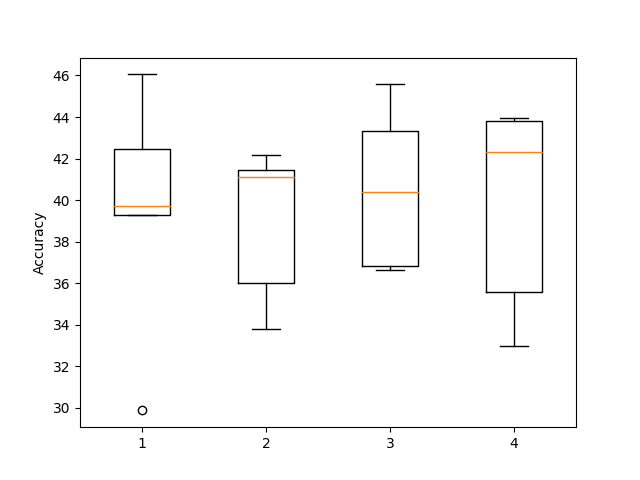

In [47]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.boxplot([epochs_10, layers_3_10, epochs_30, layers_3_30], labels=['1', '2', '3','4'])
plt.show()

<IPython.core.display.Javascript object>


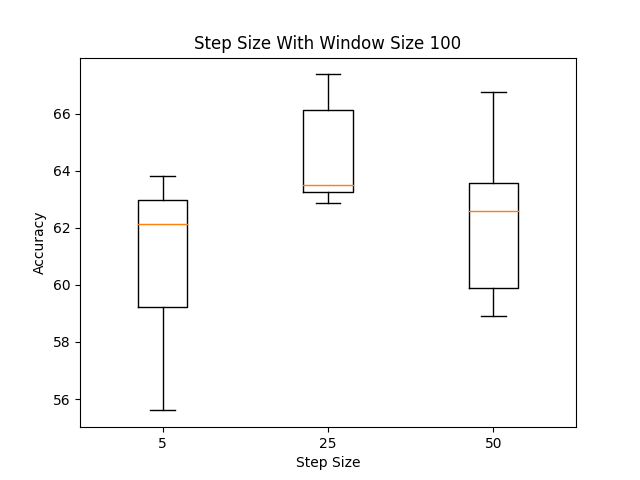

In [50]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Step Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Step Size With Window Size 100')
ax1.boxplot([epochs_40_full_data_batch_normalisation_grouped, window_100_steps_25, window_100_steps_50], labels=['5', '25', '50'])
plt.show()

<IPython.core.display.Javascript object>


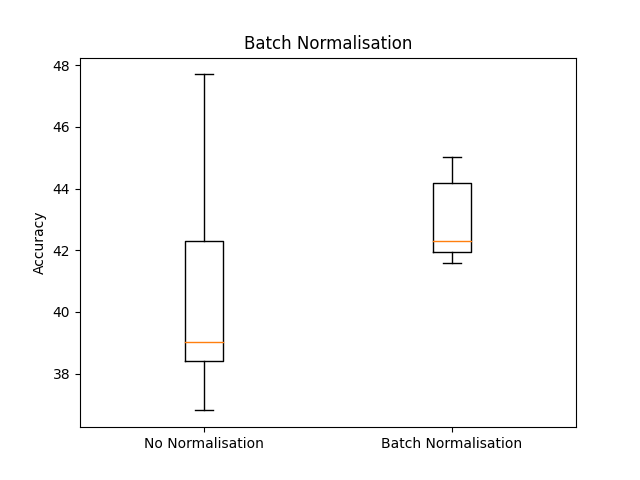

In [52]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Batch Normalisation')
ax1.boxplot([epochs_40_full_data, epochs_40_full_data_batch_normalisation], labels=['No Normalisation', 'Batch Normalisation'])
plt.show()

<IPython.core.display.Javascript object>


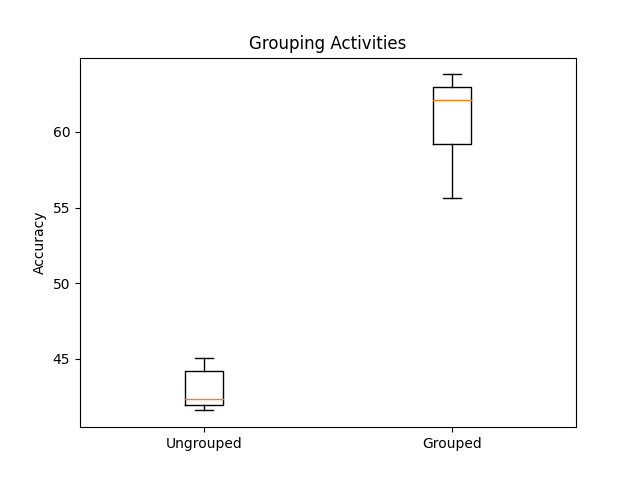

In [53]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Grouping Activities')
ax1.boxplot([epochs_40_full_data_batch_normalisation, epochs_40_full_data_batch_normalisation_grouped], labels=['Ungrouped', 'Grouped'])
plt.show()

<IPython.core.display.Javascript object>


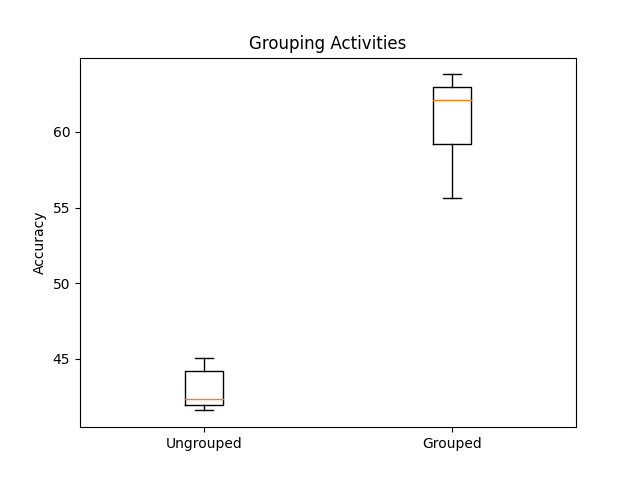

In [55]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Grouping Activities')
ax1.boxplot([epochs_40_full_data_batch_normalisation, epochs_40_full_data_batch_normalisation_grouped], labels=['Ungrouped', 'Grouped'])
plt.show()

<IPython.core.display.Javascript object>


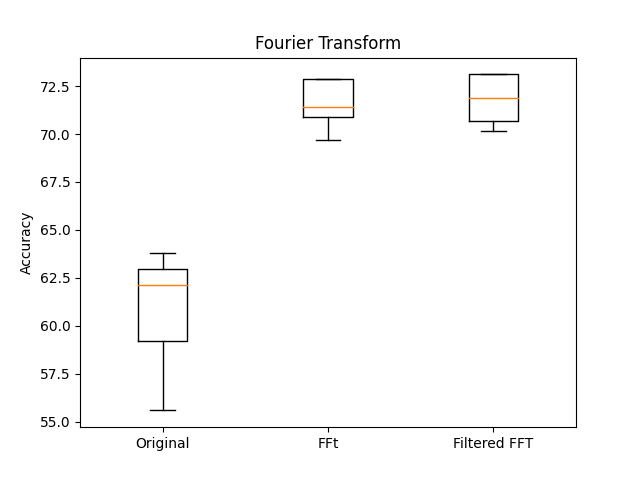

In [57]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Fourier Transform')
ax1.boxplot([epochs_40_full_data_batch_normalisation_grouped, fft_grouped, fft_filtering_01], labels=['Original', 'FFt', 'Filtered FFT'])
plt.show()